<a href="https://colab.research.google.com/github/Aafreen2603/deep-learning/blob/main/L1%2C_L2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L1 Regularization

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

In [ ]:
from torch.utils.data import DataLoader
import seaborn as sns
iris = sns.load_dataset('iris')

data = torch.tensor( iris[iris.columns[0:4]].values ).float()

labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset = torch.utils.data.TensorDataset(test_data,test_labels)
# create dataloader objects
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [ ]:
def createANewModel1():

  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer
tmpmodel=createANewModel1()[0]
print(tmpmodel)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
# print the model's parameters
for i in tmpmodel.named_parameters():
  print(i[0],i[1].shape,i[1].numel())


0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [ ]:
# train the model
# global parameter
numepochs = 1000
def trainTheModel1(L1lambda):
  trainAcc = []
  testAcc = []
  losses = []
# count the total number of weights in the model
  nweights = 0
  for pname,weight in ANNiris.named_parameters():
     if 'bias' not in pname: 
       nweights = nweights + weight.numel()
# loop over epochs
  for epochi in range(numepochs):
# loop over training data batches
   batchAcc = []
   batchLoss = []
   for X,y in train_loader:
     yHat = ANNiris(X)
     loss = lossfun(yHat,y)
     L1_term = torch.tensor(0.,requires_grad=True)
     for pname,weight in ANNiris.named_parameters():
       if 'bias' not in pname:
         L1_term = L1_term + torch.sum(torch.abs(weight))
     loss = loss + L1lambda*L1_term/nweights
     optimizer.zero_grad()
     loss.backward()
     optimizer.step()
     # compute training accuracy just for this batch
     batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
     batchLoss.append( loss.item() )
# end of batch loop...
   trainAcc.append( np.mean(batchAcc) )
   losses.append( np.mean(batchLoss) )
# test accuracy
   X,y = next(iter(test_loader)) # extract X,y from test dataloader
   predlabels = torch.argmax( ANNiris(X),axis=1 )
   testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
#function output
  return trainAcc,testAcc,losses


In [ ]:
ANNiris,lossfun,optimizer = createANewModel1()
# train the model
L1lambda = .001
trainAcc,testAcc,losses = trainTheModel1(L1lambda)

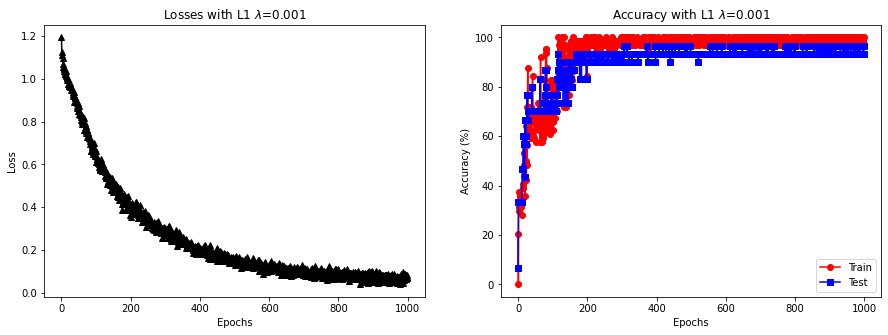

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))
ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
plt.show()

In [ ]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

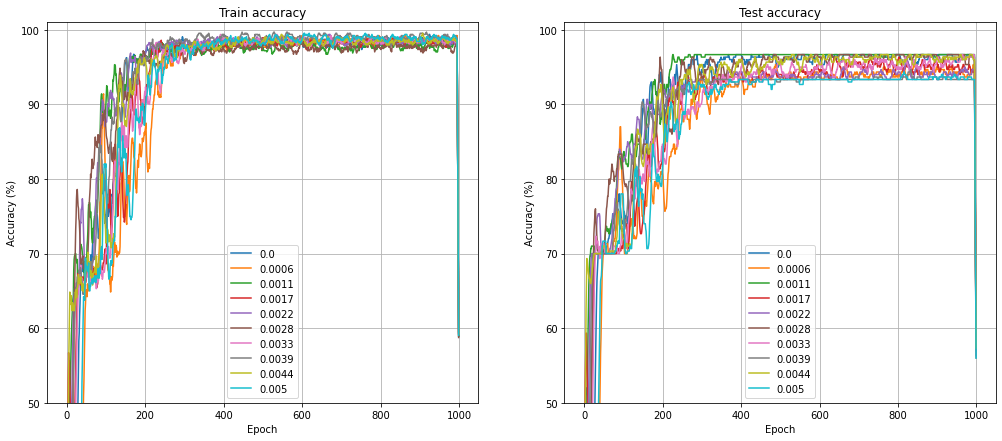

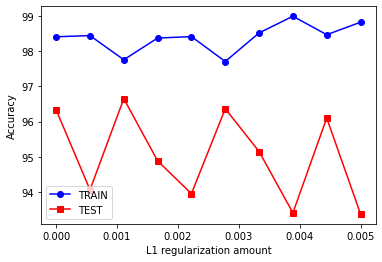

In [ ]:
  L1lambda = np.linspace(0,.005,10)
  # initialize output results matrices
  accuracyResultsTrain = np.zeros((numepochs,len(L1lambda)))
  accuracyResultsTest = np.zeros((numepochs,len(L1lambda)))
  # loop over batch sizes
  for li in range(len(L1lambda)):
    ANNiris,lossfun,optimizer = createANewModel1()
    trainAcc,testAcc,losses = trainTheModel1(L1lambda[li])
    # store data
    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li] = smooth(testAcc,10)
  # plot some results
  fig,ax = plt.subplots(1,2,figsize=(17,7))
  ax[0].plot(accuracyResultsTrain)
  ax[0].set_title('Train accuracy')
  ax[1].plot(accuracyResultsTest)
  ax[1].set_title('Test accuracy')
  leglabels = [np.round(i,4) for i in L1lambda]
  for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()
  plt.show()
  epoch_range = [500,950]
  plt.plot(L1lambda,np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),'bo-',label='TRAIN')
  plt.plot(L1lambda,np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),'rs-',label='TEST')
  plt.xlabel('L1 regularization amount')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# L2 Regularization

In [ ]:
def createANewModel(L2lambda):

  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.005,weight_decay=L2lambda)

  return ANNiris,lossfun,optimizer

In [ ]:
# global parameter
numepochs = 1000
def trainTheModel():
  trainAcc = []
  testAcc = []
  losses = []
  for epochi in range(numepochs):
    batchAcc = []
    batchLoss = []
    for X,y in train_loader:
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )
    ANNiris.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
    ANNiris.train()
  return trainAcc,testAcc,losses
     

In [ ]:
# create a model
L2lambda = .01
ANNiris,lossfun,optimizer = createANewModel(L2lambda)
# train the model
trainAcc,testAcc,losses = trainTheModel()



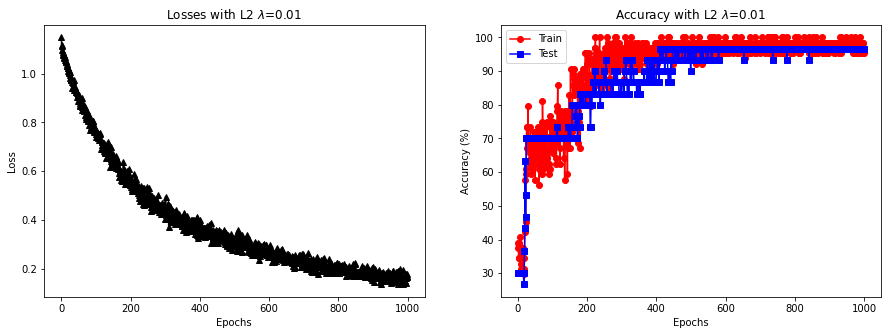

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))
ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
plt.show()

In [ ]:
# create a 1D smoothing filter
def smoothh(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [ ]:
  L2lambdas = np.linspace(0,.1,10)
  # initialize output results matrices
  accuracyResultsTrain = np.zeros((numepochs,len(L2lambdas)))
  accuracyResultsTest = np.zeros((numepochs,len(L2lambdas)))
  # loop over batch sizes
  for li in range(len(L2lambdas)):
    ANNiris,lossfun,optimizer = createANewModel(L2lambdas[li])
    trainAcc,testAcc,losses = trainTheModel()
    accuracyResultsTrain[:,li] = smoothh(trainAcc, 10)
    # store data
    # accuracyResultsTrain[:,li] = smooth1(trainAcc,10)
    accuracyResultsTest[:,li] = smoothh(testAcc,10)


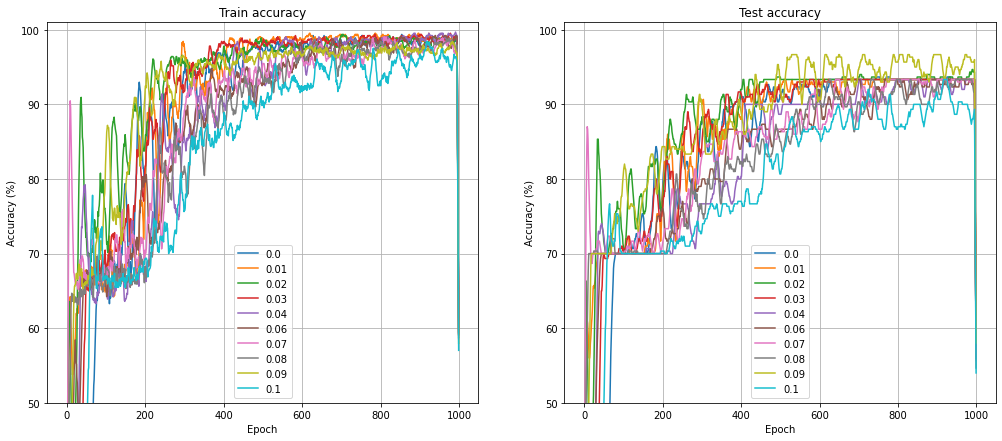

In [ ]:
  # plot some results
  fig,ax = plt.subplots(1,2,figsize=(17,7))
  ax[0].plot(accuracyResultsTrain)
  ax[0].set_title('Train accuracy')
  ax[1].plot(accuracyResultsTest)
  ax[1].set_title('Test accuracy')
  leglabels = [np.round(i,2) for i in L2lambdas]
  for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()
  plt.show()

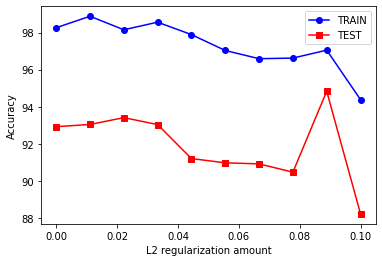

In [ ]:
  epoch_range = [500,950]
  plt.plot(L2lambdas,np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:],axis=0),'bo-',label='TRAIN')
  plt.plot(L2lambdas,np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:],axis=0),'rs-',label='TEST')
  plt.xlabel('L2 regularization amount')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()